<a href="https://colab.research.google.com/github/sanatcodes/BuySmarter/blob/main/DC_pipeline_refined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries


In [11]:
!pip install mne

In [15]:
import mne
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks

# Import EEG data


In [13]:
file_path = '/content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/data/files/eegmat/1.0.0/Subject00_1.edf'
save_path = '/content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/data/2D_topomaps_gdrive'

os.makedirs(save_path, exist_ok=True)

raw = mne.io.read_raw_edf(file_path, preload=True)
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
channel_mapping = {
    'EEG Fp1': 'Fp1', 'EEG Fp2': 'Fp2',
    'EEG F3': 'F3', 'EEG F4': 'F4',
    'EEG F7': 'F7', 'EEG F8': 'F8',
    'EEG T3': 'T7', 'EEG T4': 'T8',
    'EEG C3': 'C3', 'EEG C4': 'C4',
    'EEG T5': 'P7', 'EEG T6': 'P8',
    'EEG P3': 'P3', 'EEG P4': 'P4',
    'EEG O1': 'O1', 'EEG O2': 'O2',
    'EEG Fz': 'Fz', 'EEG Cz': 'Cz', 'EEG Pz': 'Pz',
}

if 'ECG ECG' in raw.ch_names:
    raw.drop_channels(['ECG ECG'])
    raw.drop_channels(['EEG A2-A1'])
raw.rename_channels(channel_mapping)
raw.set_montage(ten_twenty_montage)

eeg_data = raw.copy().pick(["eeg"]).load_data()
print(eeg_data.info)

Extracting EDF parameters from /content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/data/files/eegmat/1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, F7, F8, T7, T8, C3, C4, P7, P8, P3, P4, O1, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2011-01-01 00:00:00 UTC
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
 subject_info: 4 items (dict)
>


## Calculate GFP

In [16]:
# Calculate GFP
eeg_data_array = eeg_data.get_data()
gfp = np.std(eeg_data_array, axis=0)

# Identify GFP peaks
peaks, _ = find_peaks(gfp, height=np.mean(gfp) + 2 * np.std(gfp))  # Adjust threshold as needed

# Print GFP peaks for inspection
print(f"Number of peaks detected: {len(peaks)}")
print(f"Peaks: {peaks}")

# Segment data around GFP peaks (60ms snapshots)
snapshot_duration = int(60 / 1000 * raw.info['sfreq'])  # 60ms in samples
half_snapshot = snapshot_duration // 2

snapshots = []
for peak in peaks:
    if peak > half_snapshot and peak < len(gfp) - half_snapshot:
        snapshots.append(eeg_data_array[:, peak - half_snapshot : peak + half_snapshot])

# Convert snapshots to numpy array for clustering
snapshots = np.array(snapshots)

print(f"Number of snapshots created: {len(snapshots)}")
print(f"Shape of each snapshot: {snapshots[0].shape}")


Number of peaks detected: 513
Peaks: [  138   454   478   501  3224  3246  3269  3319  3517  3542  3559  3583
  3602  3646  3674  3977  4024  4041  4124  4214  4230  4255  4297  4318
  4521  4882  4928  4949  5636  5701  5724  5744  5767  5790  5811  5854
  5898  6068  6113  6319  6361  6416  6436  6461  6487  6506  6548  6593
  6610  6637  6660  6679  6698  6726  6745  6777  6865  6887  6956  6981
  7009  7109  7314  7352  7370  7888  7906  8345  8365  8394  8415  8444
  8466  8495  8510  8543  8560  8592  8613  8646  8794  9014  9485  9509
  9540 10521 11501 12488 13549 14883 15093 15119 15136 15182 15227 15245
 16774 16861 17915 17935 17960 17981 18741 18760 18788 18860 19133 20322
 20368 20635 20683 20703 20728 21735 21755 21783 21802 21941 21982 22004
 22027 22051 22098 22435 22479 22495 22523 23413 23484 23511 23532 23555
 23609 23657 23704 24112 24963 25612 25782 25905 25926 25947 25970 26013
 26037 26205 26269 26293 26310 26338 26362 26413 26432 26449 26479 26517
 26603 26622 2

### Visualise GFP and epochs

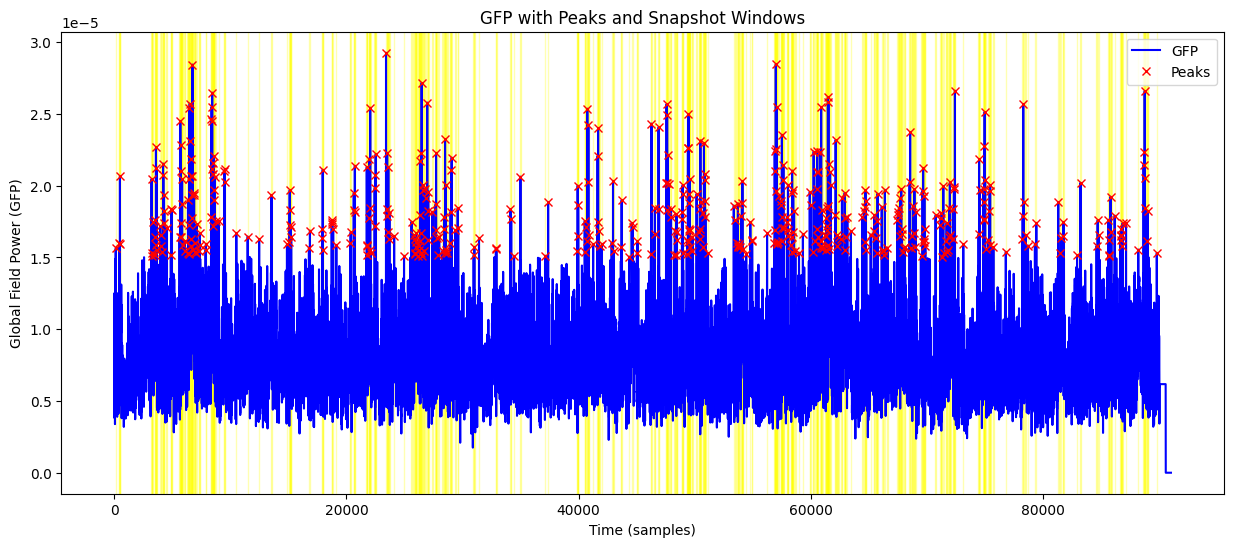

In [17]:
# Visualization
plt.figure(figsize=(15, 6))

# Plot GFP
plt.plot(gfp, label='GFP', color='blue')

# Mark peaks
plt.plot(peaks, gfp[peaks], "x", label='Peaks', color='red')

# Highlight snapshot windows
for peak in peaks:
    if peak > half_snapshot and peak < len(gfp) - half_snapshot:
        plt.axvspan(peak - half_snapshot, peak + half_snapshot, color='yellow', alpha=0.3)

plt.xlabel('Time (samples)')
plt.ylabel('Global Field Power (GFP)')
plt.title('GFP with Peaks and Snapshot Windows')
plt.legend()
plt.show()

## Epoch data


In [5]:
# Epoching the data for every 60ms
epoch_length = 0.06
sfreq = int(raw.info['sfreq'])
epoch_samples = int(sfreq * epoch_length)

data = raw.get_data()
num_epochs = data.shape[1] // epoch_samples
reshaped_data = data[:, :num_epochs * epoch_samples]
epochs = reshaped_data.reshape((num_epochs, data.shape[0], epoch_samples))
print(epochs.shape)


(3033, 19, 30)


# Create topomaps


## Creating the images


In [ ]:
for i in range(num_epochs):
    plt.figure(figsize=(20, 3)) # 100x100 pixels resolution
    avg_epoch = np.mean(epochs[i, :, :], axis=1) # Average across time points within the epoch
    mne.viz.plot_topomap(avg_epoch, eeg_data.info, show=False)
    file_name = f'topomap_epoch_{i+1}.png'
    file_path = os.path.join(save_path, file_name)
    plt.savefig(file_path)
    plt.close()

plt.subplots_adjust(left=0.01, right=0.99, top=0.9, bottom=0.1, wspace=0.02)

/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:1020: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(figsize=(size, size), layout="constrained")
<ipython-input-8-0d41b482b2cd>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 3)) # Adjust figure size for 100x100 pixels resolution


<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

## Convert Topomaps into tensors


In [7]:
from PIL import Image
import torch
from torchvision import transforms

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

tensor_list = []

for file_name in sorted(os.listdir(topomap_path)):
    if file_name.endswith('.png'):
        img_path = os.path.join(topomap_path, file_name)
        image = Image.open(img_path)
        image_tensor = transform(image)
        tensor_list.append(image_tensor)

topomap_tensors = torch.stack(tensor_list)

print(f'Shape of the tensor: {topomap_tensors.shape}')

torch.save(topomap_tensors, tensor_save_path)
print(f'Tensors saved to {tensor_save_path}')


Shape of the tensor: torch.Size([3033, 1, 100, 100])
Tensors saved to /content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/data/topomap_tensors.pt


# Conv Auto Encoder


In [8]:
# Path where topomaps are saved
topomap_path = '/content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/data/2D_topomaps_gdrive'
# Path to save tensors
tensor_save_path = '/content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/data/topomap_tensors.pt'

topomap_tensors = torch.load(tensor_save_path)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Model checkpoint code

In [ ]:
import torch
import os

def save_checkpoint(state, is_best, checkpoint_dir, filename='checkpoint.pth.tar'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(state, filepath)
    if is_best:
        best_filepath = os.path.join(checkpoint_dir, 'model_best.pth.tar')
        torch.save(state, best_filepath)


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [B, 1, 100, 100] -> [B, 16, 50, 50]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [B, 16, 50, 50] -> [B, 32, 25, 25]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)  # [B, 32, 25, 25] -> [B, 64, 19, 19]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),  # [B, 64, 19, 19] -> [B, 32, 25, 25]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 32, 25, 25] -> [B, 16, 50, 50]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 16, 50, 50] -> [B, 1, 100, 100]
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def forward(self, x):
        latent_space = self.encoder(x)
        reconstructed = self.decoder(latent_space)
        return reconstructed, latent_space

model = ConvAutoencoder()


## Train the auto encoder

In [ ]:
import torch.optim as optim
from sklearn.model_selection import train_test_split


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
batch_size = 64
dataset = torch.utils.data.TensorDataset(topomap_tensors)

train_indices, val_indices = train_test_split(range(topomap_tensors.size(0)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 20
checkpoint_dir = '/content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/Untitled Folder'
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        img = data[0]

        reconstructed, _ = model(img)
        loss = criterion(reconstructed, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            img = data[0]
            reconstructed, _ = model(img)
            loss = criterion(reconstructed, img)
            val_loss += loss.item() * img.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    is_best = val_loss < best_val_loss
    best_val_loss = min(val_loss, best_val_loss)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_val_loss': best_val_loss,
        'optimizer': optimizer.state_dict(),
    }, is_best, checkpoint_dir)


Epoch [1/20], Train Loss: 0.0504, Val Loss: 0.0364
Epoch [2/20], Train Loss: 0.0323, Val Loss: 0.0290
Epoch [3/20], Train Loss: 0.0255, Val Loss: 0.0219
Epoch [4/20], Train Loss: 0.0201, Val Loss: 0.0191
Epoch [5/20], Train Loss: 0.0184, Val Loss: 0.0176
Epoch [6/20], Train Loss: 0.0168, Val Loss: 0.0162
Epoch [7/20], Train Loss: 0.0157, Val Loss: 0.0152
Epoch [8/20], Train Loss: 0.0147, Val Loss: 0.0146
Epoch [9/20], Train Loss: 0.0138, Val Loss: 0.0137
Epoch [10/20], Train Loss: 0.0132, Val Loss: 0.0128
Epoch [11/20], Train Loss: 0.0125, Val Loss: 0.0123
Epoch [12/20], Train Loss: 0.0120, Val Loss: 0.0118
Epoch [13/20], Train Loss: 0.0115, Val Loss: 0.0118
Epoch [14/20], Train Loss: 0.0113, Val Loss: 0.0109
Epoch [15/20], Train Loss: 0.0106, Val Loss: 0.0104
Epoch [16/20], Train Loss: 0.0102, Val Loss: 0.0101
Epoch [17/20], Train Loss: 0.0098, Val Loss: 0.0097
Epoch [18/20], Train Loss: 0.0095, Val Loss: 0.0093
Epoch [19/20], Train Loss: 0.0091, Val Loss: 0.0090
Epoch [20/20], Train 

## Extract the latent space

In [ ]:
model.eval()

latent_features = []

with torch.no_grad():
    for data in dataloader:
        img = data[0]
        _, latent = model(img)
        latent_features.append(latent)

latent_features = torch.cat(latent_features)
latent_features = latent_features.view(latent_features.size(0), -1)

print(f'Shape of latent features: {latent_features.shape}')


Shape of latent features: torch.Size([3033, 23104])


## Visualise latent features with t-SNE

<ipython-input-22-3a39bdbc1ed6>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_features_2d_tsne[:, 0], latent_features_2d_tsne[:, 1], s=5, cmap='viridis')


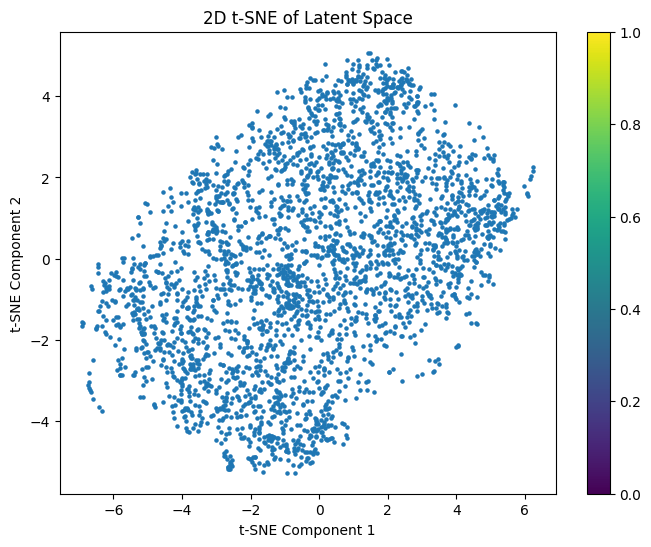

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
latent_features_2d_tsne = tsne.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
plt.scatter(latent_features_2d_tsne[:, 0], latent_features_2d_tsne[:, 1], s=5, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE of Latent Space')
plt.colorbar()
plt.show()


## visualise latent space with PCA

<ipython-input-25-9f51a0ca1998>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_features_2d[:, 0], latent_features_2d[:, 1], s=2, cmap='viridis')


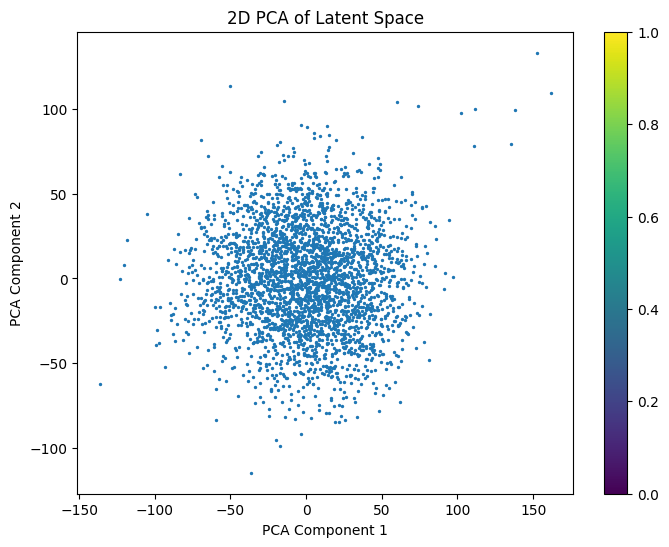

In [ ]:
optimal_components = 5

pca = PCA(n_components=optimal_components)
latent_features_reduced = pca.fit_transform(latent_features)

pca_2d = PCA(n_components=2)
latent_features_2d = pca_2d.fit_transform(latent_features)

plt.figure(figsize=(8, 6))
plt.scatter(latent_features_2d[:, 0], latent_features_2d[:, 1], s=2, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Latent Space')
plt.colorbar()
plt.show()


## Apply elbow method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

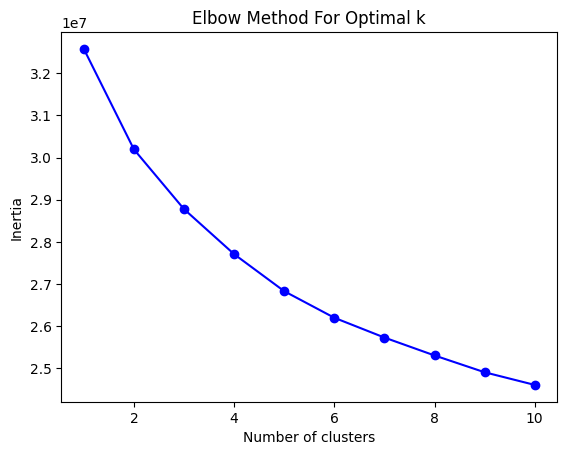

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=50)
latent_features_reduced = pca.fit_transform(latent_features)


inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(latent_features_reduced)
    inertia.append(kmeans.inertia_)


plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


## Finding optimal clusters using BIC method

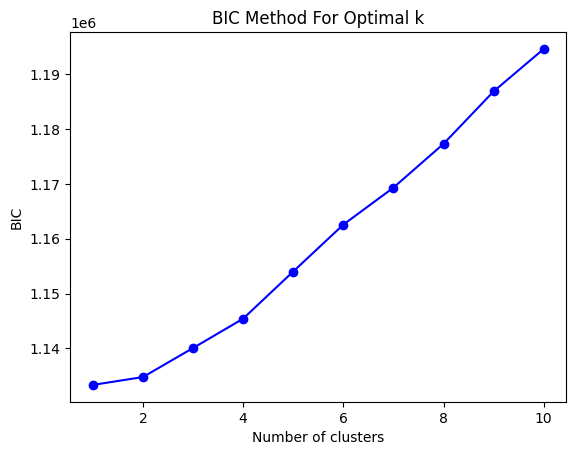

Optimal number of clusters according to BIC: 1


In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

pca = PCA(n_components=50)
latent_features_reduced = pca.fit_transform(latent_features)

bic = []
k_values = range(1, 11)

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(latent_features_reduced)
    bic.append(gmm.bic(latent_features_reduced))


plt.plot(k_values, bic, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC Method For Optimal k')
plt.show()


optimal_k = k_values[bic.index(min(bic))]
print(f'Optimal number of clusters according to BIC: {optimal_k}')


## Cluster in latent space based on optimal clusters

In [ ]:
import os
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(latent_features_reduced)

# Save cluster assignments
cluster_save_dir = '/content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/clusters'
cluster_save_path = os.path.join(cluster_save_dir, 'cluster_assignments.pt')


os.makedirs(cluster_save_dir, exist_ok=True)


torch.save(clusters, cluster_save_path)
print(f'Clusters saved to {cluster_save_path}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters saved to /content/drive/MyDrive/TU Dublin/PhD/DC for microstates with CAE experiment/clusters/cluster_assignments.pt


# Deep Clustering

## Define DEC class

In [ ]:
import torch.nn.functional as F

class DEC(nn.Module):
    def __init__(self, autoencoder, n_clusters, cluster_centers):
        super(DEC, self).__init__()
        self.autoencoder = autoencoder
        self.cluster_centers = nn.Parameter(torch.tensor(cluster_centers, dtype=torch.float))
        self.n_clusters = n_clusters

    def forward(self, x):
        _, latent = self.autoencoder(x)
        q = self.soft_assign(latent)
        return q, latent

    def soft_assign(self, z):
        # Calculate squared distances to cluster centers
        z = z.unsqueeze(1) - self.cluster_centers
        z = torch.sum(z ** 2, dim=2)
        q = 1.0 / (1.0 + z)
        q = q ** ((1.0 + 1.0) / 2.0)
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

# Initialize DEC model
dec_model = DEC(model, n_clusters=optimal_k, cluster_centers=initial_cluster_centers)


## Train DEC

In [ ]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


dec_optimizer = optim.Adam(dec_model.parameters(), lr=1e-3)
num_dec_epochs = 20
update_interval = 1

for epoch in range(num_dec_epochs):
    if epoch % update_interval == 0:
        dec_model.eval()
        q, _ = dec_model(torch.tensor(topomap_tensors, dtype=torch.float))
        p = target_distribution(q).detach()

    dec_model.train()
    running_loss = 0.0
    for data in train_loader:
        img = data[0]


        q, latent = dec_model(img)
        loss = F.kl_div(q.log(), p)


        dec_optimizer.zero_grad()
        loss.backward()
        dec_optimizer.step()

        running_loss += loss.item() * img.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_dec_epochs}], Train Loss: {train_loss:.4f}')


## Visualise clusters

### Extract latent features from DEC

In [ ]:

dec_model.eval()

# soft assignments
latent_features = []
soft_assignments = []

with torch.no_grad():
    for data in train_loader:
        img = data[0]
        q, latent = dec_model(img)
        latent_features.append(latent)
        soft_assignments.append(q)

# Concatenate
latent_features = torch.cat(latent_features)
soft_assignments = torch.cat(soft_assignments)

# Assign each point to cluster
cluster_assignments = torch.argmax(soft_assignments, dim=1)

print(f'Shape of latent features: {latent_features.shape}')
print(f'Shape of cluster assignments: {cluster_assignments.shape}')


### Visualise with PCA or t-SNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Option 1: PCA
pca = PCA(n_components=2)
latent_features_2d = pca.fit_transform(latent_features)

# Option 2: t-SNE
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# latent_features_2d = tsne.fit_transform(latent_features)

print(f'Shape of 2D latent features: {latent_features_2d.shape}')

# Plot the 2D latent features with cluster assignments
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_features_2d[:, 0], latent_features_2d[:, 1], c=cluster_assignments, cmap='viridis', s=5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Visualization of Clusters in Latent Space')
plt.colorbar(scatter, ticks=range(optimal_k))
plt.show()
